In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
def vals2map(vals):
    if vals.shape==(256,):
        map = vals.reshape(16, 16).copy()
    elif vals.shape==(1024,):
        offsets = [(0, 0), (0, 1), (1, 0), (1, 1)]
        assert vals.shape==(1024,)
        map = np.full((32, 32), fill_value=np.nan)
        for i, (y, x) in enumerate(offsets):
            map[y::2, x::2] = vals[i*256:(i+1)*256].reshape(16, 16)
    else:
        raise ValueError(f"Incorrect shape: {vals.shape}")
    return map

In [3]:
saved = torch.load('../cache/RF.temporal.pt')
u0 = saved['u0']
u1 = saved['u1']
rf_t0 = np.zeros(u0.shape)
rf_t1 = np.zeros(u1.shape)
rf_t0_m2 = np.zeros(u0.shape)
rf_t1_m2 = np.zeros(u1.shape)
rf_t0_samples = []
rf_t1_samples = []
count = 0

fvus = np.empty((128, 128))
fvus_0 = np.empty((128, 128))
fvus_1 = np.empty((128, 128))
A0 = np.empty((128, 128))
A1 = np.empty((128, 128))
z0 = np.empty((128, 128))
z1 = np.empty((128, 128))
x0 = np.empty((128, 128))
y0 = np.empty((128, 128))
sigma0 = np.empty((128, 128))
x1 = np.empty((128, 128))
y1 = np.empty((128, 128))
sigma1 = np.empty((128, 128))

for i in range(4):
    for j in range(4):
        tile_idx = 4*i+j+1
        saved = torch.load('../cache/RF.fit_tile{:02d}.pt'.format(tile_idx))
        fvus[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['fvus'])
        fvus_0[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['fvus_0'])
        fvus_1[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['fvus_1'])
        rfs_t0, rfs_t1 = saved['rfs_t0'], saved['rfs_t1']
        rf_t0 += np.nansum(rfs_t0, axis=0)
        rf_t1 += np.nansum(rfs_t1, axis=0)
        count += np.all(~np.isnan(rfs_t0), axis=1).sum()
        rf_t0_m2 += np.nansum(rfs_t0**2, axis=0)
        rf_t1_m2 += np.nansum(rfs_t1**2, axis=0)
        idxs, = np.all(~np.isnan(rfs_t0), axis=1).nonzero()
        idxs = rng.choice(idxs, 5, replace=False)
        rf_t0_samples.append(rfs_t0[idxs])
        rf_t1_samples.append(rfs_t1[idxs])
        
        rfs_s0, rfs_s1 = saved['rfs_s0'], saved['rfs_s1']
        params_s0, params_s1 = saved['params_s0'], saved['params_s1']
        _A0 = ((rfs_t0[:, :, None, None]*rfs_s0[:, None, :, :])**2).mean(axis=(1, 2, 3))
        # _A0 = ((params_s0[:, 0][:, None]*rfs_t0)**2).mean(axis=1)
        A0[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(_A0)
        _z0 = (rfs_t0*u0).sum(axis=1)
        z0[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(_z0)
        _A1 = ((rfs_t1[:, :, None, None]*rfs_s1[:, None, :, :])**2).mean(axis=(1, 2, 3))
        # _A1 = ((params_s1[:, 0][:, None]*rfs_t1)**2).mean(axis=1)
        A1[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(_A1)
        _z1 = (rfs_t1*u1).sum(axis=1)
        z1[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(_z1)
        x0[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(params_s0[:, 1])
        y0[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(params_s0[:, 2])
        sigma0[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(params_s0[:, 3])
        x1[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(params_s1[:, 1])
        y1[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(params_s1[:, 2])
        sigma1[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(params_s1[:, 3])
rf_t0 /= count
rf_t1 /= count
rf_t0_var = rf_t0_m2/count-rf_t0**2
rf_t1_var = rf_t1_m2/count-rf_t1**2
rf_t0_samples = np.concatenate(rf_t0_samples)
rf_t1_samples = np.concatenate(rf_t1_samples)

# Fitting quality

15414 good channels (94.1%)


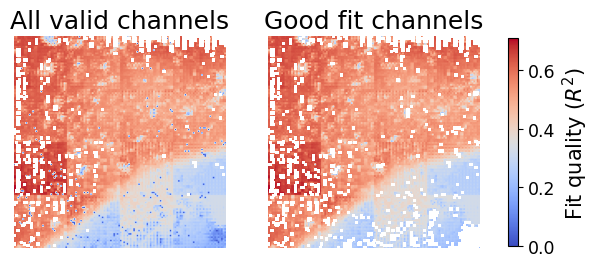

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
h = axes[0].imshow(1-fvus, vmin=0, cmap='coolwarm')
axes[0].axis('off')
axes[0].set_title('All valid channels')

fvu_th = 0.8
_fvus = fvus.copy()
mask = _fvus>fvu_th
_fvus[mask] = np.nan
h = axes[1].imshow(1-_fvus, vmin=0, cmap='coolwarm')
axes[1].axis('off')
axes[1].set_title('Good fit channels')
plt.colorbar(h, shrink=0.9, ax=axes, label=r'Fit quality ($R^2$)')
fig.savefig('fit.quality.svg')

r_idxs, c_idxs = (~np.isnan(_fvus)).nonzero()
print('{} good channels ({:.1%})'.format(len(r_idxs), len(r_idxs)/(16*1024)))

# Component amplitude

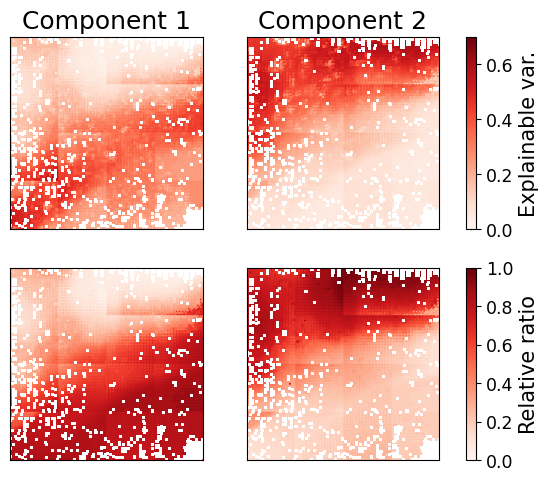

In [5]:
ratios_0 = (1-fvus_0)/(1-fvus)
ratios_1 = (1-fvus_1)/(1-fvus)

fig, axes = plt.subplots(2, 2, figsize=(7, 5.5))
for i, ax in enumerate(axes.ravel()):
    if i==0:
        vals = 1-fvus_0
    if i==1:
        vals = 1-fvus_1
    if i==2:
        vals = ratios_0.copy()
    if i==3:
        vals = ratios_1.copy()
    vals[mask] = np.nan
    if i in [0, 1]:
        # vmax = np.nanmax(np.stack([1-fvus_0, 1-fvus_1]))
        vmax = 0.7
    if i in [2, 3]:
        # vmax = np.nanmax(np.stack([(1-fvus_0)/(1-fvus), (1-fvus_1)/(1-fvus)]))
        vmax = 1.
    h = ax.imshow(vals, vmin=0, vmax=vmax, cmap='Reds')
    for sp in ax.spines.values():
        sp.set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==1:
        fig.colorbar(h, ax=axes[0], label='Explainable var.')
    if i==3:
        fig.colorbar(h, ax=axes[1], label='Relative ratio')
axes[0, 0].set_title('Component 1')
axes[0, 1].set_title('Component 2')

plt.show()

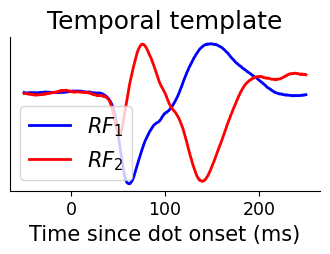

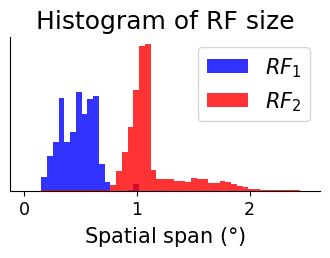

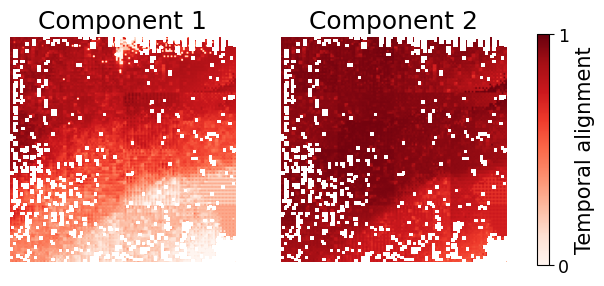

In [6]:
taus = np.arange(601)*0.5-50
fig, ax = plt.subplots(figsize=(4, 2))
# ax.plot(taus, u0, color='blue')
# ax.plot(taus, u1, color='red')
ax.plot(taus, rf_t0, color='blue')
ax.plot(taus, rf_t1, color='red')
ax.set_xlabel(r'Time since dot onset (ms)')
ax.set_yticks([])
ax.set_title('Temporal template')
ax.legend(['$RF_1$', '$RF_2$'])
fig.savefig('temporal.profiles.svg')

fig, ax = plt.subplots(figsize=(4, 2))
ax.hist(sigma0.reshape(-1), np.linspace(0, 2.5, 50), density=True, color='blue', alpha=0.8)
ax.hist(sigma1.reshape(-1), np.linspace(0, 2.5, 50), density=True, color='red', alpha=0.8)
ax.set_xlabel(r'Spatial span ($\degree$)')
ax.set_yticks([])
ax.set_title('Histogram of RF size')
# ax.legend([r'$\sigma_1$', r'$\sigma_2$'])
ax.legend(['$RF_1$', '$RF_2$'])
fig.savefig('spatial.spans.svg')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, ax in enumerate(axes):
    if i==0:
        vals = z0.copy()
        title = 'Component 1'
    if i==1:
        vals = z1.copy()
        title = 'Component 2'
    vals[mask] = np.nan
    h = ax.imshow(vals, vmin=0, vmax=1, cmap='Reds')
    ax.set_title(title)
    ax.axis('off')
cbar = fig.colorbar(h, ax=axes)
cbar.set_label('Temporal alignment')
cbar.set_ticks(ticks=[0, 1])
fig.savefig('component.alignment.svg')

# RF map for each component

## Histogram of RF coordinates

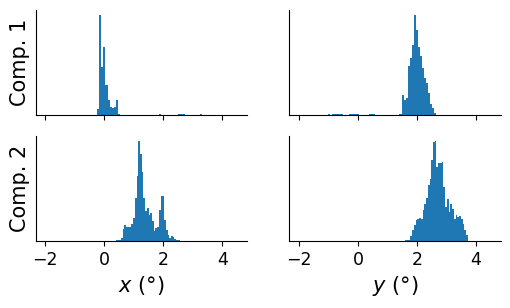

In [7]:
_, axes = plt.subplots(2, 2, figsize=(6, 3), sharex=True)
for i, ax in enumerate(axes.ravel()):
    if i==0:
        vals = x0.copy()
        title = '$x_0$'
    if i==1:
        vals = y0.copy()
        title = '$y_0$'
    if i==2:
        vals = x1.copy()
        title = '$x_1$'
    if i==3:
        vals = y1.copy()
        title = '$y_1$'
    vals[mask] = np.nan
    vals = vals.reshape(-1)
    ax.hist(vals, 80, density=True)
    ax.set_yticks([])
axes[0, 0].set_ylabel('Comp. 1')
axes[1, 0].set_ylabel('Comp. 2')
axes[1, 0].set_xlabel(r'$x$ ($\degree$)')
axes[1, 1].set_xlabel(r'$y$ ($\degree$)')
plt.show()

## Retinotopic maps

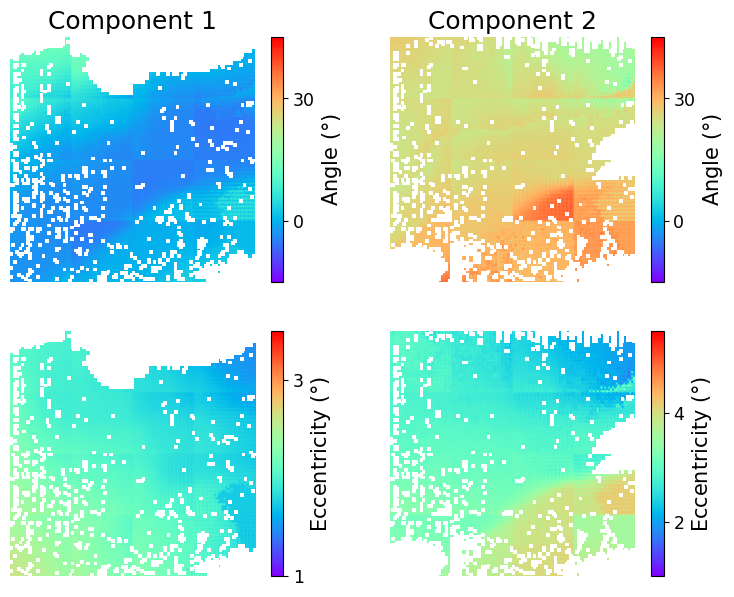

In [17]:
mask0 = mask|(ratios_0<0.1)|(z0<0.)
for vals in [x0, y0, sigma0]:
    v_mean = np.nanmean(vals[~mask0])
    v_std = np.nanstd(vals[~mask0])
    mask0[np.abs(vals-v_mean)>3*v_std] = True
mask1 = mask|(ratios_1<0.15)|(z1<0.2)
for vals in [x1, y1, sigma1]:
    v_mean = np.nanmean(vals[~mask1])
    v_std = np.nanstd(vals[~mask1])
    mask1[np.abs(vals-v_mean)>3*v_std] = True
angs0 = np.arctan2(x0, y0)/np.pi*180
eccs0 = (x0**2+y0**2)**0.5
angs1 = np.arctan2(x1, y1)/np.pi*180
eccs1 = (x1**2+y1**2)**0.5

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
for i, ax in enumerate(axes.ravel()):
    if i==0:
        vals = x0.copy()
        vmin, vmax = -0.5, 1
        ticks = [0, 0.5]
        title = '$x_1$'
        
        vals = angs0.copy()
        vmin, vmax = -15, 45
        ticks = [0, 30]
        title = 'Angle'
    if i==1:
        vals = x1.copy()
        vmin, vmax = -1.5, 3
        ticks = [0, 2]
        title = '$x_2$'
        
        vals = angs1.copy()
        vmin, vmax = -15, 45
        ticks = [0, 30]
        title = 'Angle'
    if i==2:
        vals = y0.copy()
        vmin, vmax = 1, 3.5
        ticks = [2, 3]
        title = '$y_1$'
        
        vals = eccs0.copy()
        vmin, vmax = 1, 3.5
        ticks = [1, 3]
        title = 'Eccentricity'
    if i==3:
        vals = y1.copy()
        vmin, vmax = 1, 5.5
        ticks = [2, 4]
        title = '$y_2$'
        
        vals = eccs1.copy()
        vmin, vmax = 1, 5.5
        ticks = [2, 4]
        title = 'Eccentricity'
    # vmin, vmax = None, None
    # ticks = None
    # if i==4:
    #     vals = sigma0.copy()
    #     vmin, vmax = 0.1, 1.5
    #     title = r'$\sigma_0$'
    # if i==5:
    #     vals = sigma1.copy()
    #     vmin, vmax = 0.2, 4
        # title = r'$\sigma_1$'
    if i%2==0:
        vals[mask0] = np.nan
    if i%2==1:
        vals[mask1] = np.nan
    h = ax.imshow(vals, vmin=vmin, vmax=vmax, cmap='rainbow')
    ax.axis('off')
    plt.colorbar(h, ax=ax, ticks=ticks, label=title+r' ($\degree$)')
    # if i==1:
    #     plt.colorbar(h, ax=axes[0], label=r'$x$ ($\degree$)')
    # if i==3:
    #     plt.colorbar(h, ax=axes[1], label=r'$y$ ($\degree$)')
axes[0, 0].set_title('Component 1')
axes[0, 1].set_title('Component 2')
fig.savefig(FIG_PATH/'mixed.rf.mapping_dense.pdf')

plt.show()